In [1]:
import pandas as pd
import numpy as np

VER = 1

train = pd.read_csv("dataset/train.csv")
test = pd.read_csv("dataset/test.csv")

In [2]:
for df in [train, test]:
  df["Sex"] = df["Sex"].map({"male": 0, "female": 1}).astype("float32")

In [3]:
FEATURES = ["Sex", "Age", "Height", "Weight", "Duration", "Heart_Rate", "Body_Temp"]
TARGET = "Calories"

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Embedding
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import Activation
import tensorflow.keras.backend as K

print("TF Version", tf.__version__)

TF Version 2.17.1


In [5]:
def build_model(size=len(FEATURES)):
  x_in = Input(shape=(size, ))
  x = Dense(32)(x_in)
  x = BatchNormalization()(x)
  x = Activation("swish")(x)
  
  x = Dense(64)(x)
  x = BatchNormalization()(x)
  x = Activation("swish")(x)
  
  x = Dense(1, activation="linear")(x)
  model = Model(inputs=x_in, outputs=x)
  return model

In [6]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

def make_callbacks():
  lr_callback = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verboe=1,
    min_lr=1e-6
  )
  early_stop_cb = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    mode="min",
    verbose=1
  )
  return [lr_callback, early_stop_cb]

EPOCHS = 100

In [10]:
import time
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof = np.zeros(len(train))
pred = np.zeros(len(test))

for i, (train_idx, valid_idx) in enumerate(kf.split(train)):
  print(f"\n{'#'*28}")
  print(f"{'#'*10} Fold {i+1} {'#'*10}")
  print(f"{'#'*28}")
  
  X_train = train.loc[train_idx, FEATURES].copy()
  y_train = np.log1p(train.loc[train_idx, TARGET])
  
  X_valid = train.loc[valid_idx, FEATURES].copy()
  y_valid = np.log1p(train.loc[valid_idx, TARGET])
  
  X_test = test[FEATURES].copy()
  
  print("Normalizing…", end="")
  norm_cols = [c for c in FEATURES if c not in []]
  means = X_train[norm_cols].mean()
  stds = X_train[norm_cols].std()
  stds = stds.replace(0, 1)
  X_train[norm_cols] = (X_train[norm_cols] - means) / stds
  X_valid[norm_cols] = (X_valid[norm_cols] - means) / stds
  X_test[norm_cols] = (X_test[norm_cols] - means) / stds
  print("done")
  
  start = time.time()
  
  K.clear_session()
  model = build_model(X_train.shape[1])
  model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                loss="mse",
                metrics=[tf.keras.metrics.RootMeanSquaredError()],
              )
  model.fit(X_train, y_train,
            validation_data=(X_valid, y_valid),
            callbacks=make_callbacks(),
            batch_size=256, epochs=EPOCHS, verbose=2)
  
  oof[valid_idx] = model.predict(X_valid, batch_size=512, verbose=2).flatten()
  pred += model.predict(X_test, batch_size=512, verbose=2).flatten()
  
  rmse = np.sqrt(mean_squared_error(y_valid, oof[valid_idx]))
  print(f"Fold {i+1} RMSE: {rmse:.4f}")
  print(f"Feature engineering & training time: {time.time() - start:.1f} sec")

pred /= FOLDS


############################
########## Fold 1 ##########
############################
Normalizing…done
Epoch 1/100
2344/2344 - 6s - 2ms/step - loss: 0.7590 - root_mean_squared_error: 0.8712 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1013 - learning_rate: 0.0010
Epoch 2/100
2344/2344 - 4s - 2ms/step - loss: 0.0130 - root_mean_squared_error: 0.1140 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0874 - learning_rate: 0.0010
Epoch 3/100
2344/2344 - 4s - 2ms/step - loss: 0.0116 - root_mean_squared_error: 0.1078 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0829 - learning_rate: 0.0010
Epoch 4/100
2344/2344 - 4s - 2ms/step - loss: 0.0107 - root_mean_squared_error: 0.1036 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0760 - learning_rate: 0.0010
Epoch 5/100
2344/2344 - 4s - 2ms/step - loss: 0.0102 - root_mean_squared_error: 0.1008 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0789 - learning_rate: 0.0010
Epoch 6/100
2344/2344 - 4s - 2ms/step - loss: 0.0102 - 

In [11]:
full_rmse = np.sqrt(mean_squared_error(np.log1p(train[TARGET]), oof))
print(f"Overall CV RMSE: {full_rmse:.5f}")
np.save(f"oof_v{VER}", oof)

Overall CV RMSE: 0.06245


In [13]:
mn = train.Calories.min()
mx = train.Calories.max()
test["Calories"] = np.clip(np.expm1(pred), mn, mx)
test[["id", "Calories"]].to_csv(f"dataset/submission_v{VER}.csv", index=False)
test[["id", "Calories"]].head()

,id,Calories
0,750000,27.236144
1,750001,108.132420
2,750002,86.360912
3,750003,125.304712
4,750004,76.406454


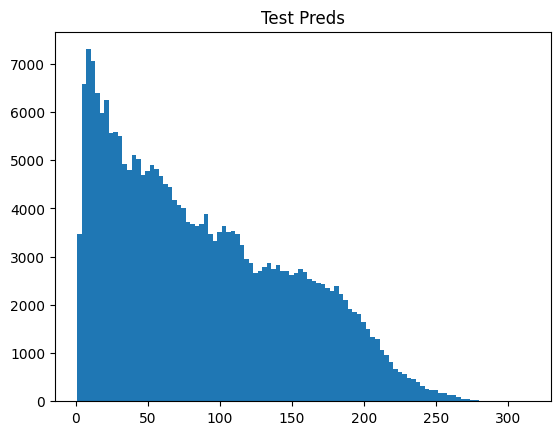

In [14]:
import matplotlib.pyplot as plt
plt.hist(test["Calories"], bins=100)
plt.title("Test Preds")
plt.show()